In [1]:
from IPython.core.display import display, HTML

# Set jupyter screen width to 100% and some pandas options
display(HTML("<style>.container { width:100% !important; }</style>"))

# Add a button for toggling code on and off
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code in this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

# Preparing Machine Learning Models for Real-Time Scoring with Sklearn Pipelines and Flask

## We are going to cover the following:
### --> Typical sequence of data cleaning, feature engineering, model training steps in a machine learning project
### --> The challenge of trying to reproduce these steps in real-time in the live scoring environment
### --> Standard sklearn pipeline: how can it help us address this challenge - but only partly
### --> Customizing sklearn pipeline to build solve our challenge in an e2e fashion
### --> Using Flask to serve a ML model as a REST API

# ------------------------------------------------------------------------------------------------------
# PART 0
## LOADING PACKAGES

In [2]:
### Load necessary packages
print('Loading standard Python packages...')

# General, data handling and visualization
import platform
import os
import sys
from shutil import copyfile, copytree, rmtree
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
import json
%matplotlib inline

# Data preprocessing, ML model training & validation
#from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics
from sklearn.externals import joblib # to save models

# Pipelining
from sklearn.base import BaseEstimator, TransformerMixin # for definition of custom transformers
from sklearn.pipeline import Pipeline

# Datetime conversions
import datetime
import calendar

# Set some pandas options
pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 999)

print('Standard Python packages successfully loaded.')

Loading standard Python packages...
Standard Python packages successfully loaded.


In [3]:
### Load helper functions
print('Importing custom helper functions...')

# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

from src.helper_functions import predict, validate, plot_ROC_curve, plot_precision_recall_curve

print('Helper functions imported.')

Importing custom helper functions...
Helper functions imported.


# ------------------------------------------------------------------------------------------------------
# PART 1
## BUSINESS PROBLEM AND AVAILABLE DATA

### The task:
### --> Develop a machine learning model that predicts probability of default of credit applicants
### --> Deliver the model in a format that can be used for scoring of credit applications in real-time

### The dataset:
### --> We will be using a modified open-source German credit scoring dataset. This is a "faked" dataset, used here for demo purposes only(!)
### --> Original dataset is available under https://www.kaggle.com/uciml/german-credit/data

## DATA EXPLORATION

Reading in selected file...
File successfully read in. Analyzing...

Table dimensions:
Number of rows: 1000
Number of columns: 12

Overview of the first five table rows:


,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Gender,Purchase_date,Birth_date,Device,Risk_label
131,2,own,little,little,6887,36,education,male,2020-03-12,1991-03-12,Samsung Fantastic,1
203,2,rent,little,little,902,12,education,male,2020-02-24,1999-02-24,Ericsson Very Old,1
50,1,own,NaN,moderate,2333,24,furniture/equipment,male,2020-04-26,1991-04-26,Nokia Old,0
585,2,rent,little,little,2039,18,furniture/equipment,female,2020-02-02,2000-02-02,Huawei Awesome,1
138,2,own,NaN,moderate,2728,15,radio/TV,male,2020-01-16,1985-01-16,iPhone 9,0



Summary of numeric features


,Job,Credit amount,Duration,Risk_label
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,1.904000,3271.258000,20.903000,0.300000
std,0.653614,2822.736876,12.058814,0.458487
min,0.000000,250.000000,4.000000,0.000000
25%,2.000000,1365.500000,12.000000,0.000000
50%,2.000000,2319.500000,18.000000,0.000000
75%,2.000000,3972.250000,24.000000,1.000000
max,3.000000,18424.000000,72.000000,1.000000



Summary of categorical features


,Housing,Saving accounts,Checking account,Purpose,Gender,Purchase_date,Birth_date,Device
count,1000,817,606,1000,1000,1000,1000,1000
unique,3,4,3,8,2,134,895,16
top,own,little,little,car,male,2020-05-07 00:00:00,1997-02-13 00:00:00,iPhone 11 Black
freq,713,603,274,337,690,14,4,117
first,NaN,NaN,NaN,NaN,NaN,2020-01-01 00:00:00,1945-01-09 00:00:00,NaN
last,NaN,NaN,NaN,NaN,NaN,2020-05-14 00:00:00,2001-05-11 00:00:00,NaN



Number of missing values per column:


Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
Gender                0
Purchase_date         0
Birth_date            0
Device                0
Risk_label            0
dtype: int64


Number of high risk (label == 1) vs. low risk (label == 0) applicants:


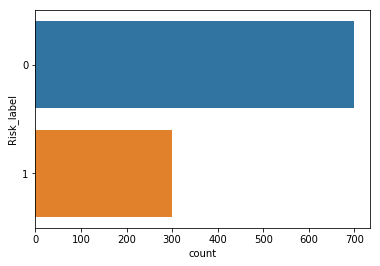

0    700
1    300
Name: Risk_label, dtype: int64


Distribution of devices used:


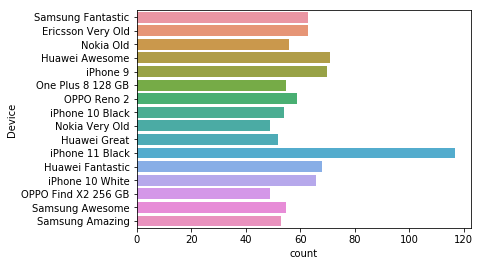


Number of unique values in the "Job" column:


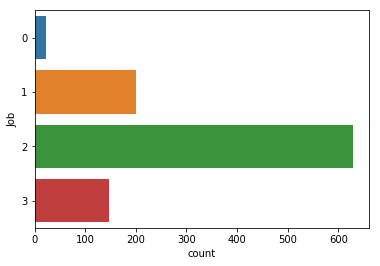

In [4]:
# Load dataset
print('Reading in selected file...')
df_original = pd.read_csv('../data/kaggle_german_credit_data_modified.csv',
                          parse_dates = ['Purchase_date', 'Birth_date'],
                          low_memory=False)

df_original = shuffle(df_original, random_state=123)
df = df_original.copy()
print('File successfully read in. Analyzing...')
print()
print('Table dimensions:')
print('Number of rows:', df.shape[0])
print('Number of columns:', df.shape[1])
print()
print('Overview of the first five table rows:')
display(df.head())
#print('Column datatypes:')
#print(df.dtypes)
print()
print('Summary of numeric features')
display(df.describe())
print()
print('Summary of categorical features')
display(df.describe(include=['object', 'datetime']))
print()
print('Number of missing values per column:')
display(df.isna().sum())
print()
print('Number of high risk (label == 1) vs. low risk (label == 0) applicants:')
sns.countplot(y='Risk_label', data=df)
plt.show()
display(df['Risk_label'].value_counts())
print()
print('Distribution of devices used:')
sns.countplot(y='Device', data=df)
plt.show()
print()
print('Number of unique values in the "Job" column:')
sns.countplot(y='Job', data=df)
plt.show()

### --> We would normally take many more data exploration steps, we skip them here for the sake of brevity.
-----------

### Our initial conclusions (example):
### --> We will need to deal with missing values in savings account and checking account columns
### --> We will want to recode the "purchase date" and "birth date" columns into something useful, like e.g. purchase date into day of the week and birth date into age of the applicant
### --> A credit risk analyst told us that the risk profile of iPhone users is different than that of people using other devices. We will want to recode the "device" column accordingly
### --> The job column looks like an integer-encoded categorical feature
-----------

# ------------------------------------------------------------------------------------------------------
# PART 2
## DATA CLEANING, FEATURE ENGINEERING, MODEL TRAINING

## DATA CLEANING

#### Fill missing values in savings account and checking account columns

In [5]:
print('Number of missing values in savings account and checking account columns:')
display(df[['Saving accounts', 'Checking account']].isna().sum())

Number of missing values in savings account and checking account columns:


Saving accounts     183
Checking account    394
dtype: int64

In [6]:
print('Filling missing values...')
for column in df[['Saving accounts', 'Checking account']]:
    df[column] = df[column].fillna('Missing')

print('Done.')

Filling missing values...
Done.


In [7]:
print('Number of missing values in savings account and checking account columns:')
display(df[['Saving accounts', 'Checking account']].isna().sum())

Number of missing values in savings account and checking account columns:


Saving accounts     0
Checking account    0
dtype: int64

#### Cast integer-encoded "Job" column to string (all non-numeric features will be one-hot encoded at a later stage)

In [8]:
print('Dtype of the "Job" column:')
display(df['Job'].dtype)

Dtype of the "Job" column:


dtype('int64')

In [9]:
print('Casting "Job" column to string...')
df['Job'] = df['Job'].astype(str)
print('Done.')

Casting "Job" column to string...
Done.


In [10]:
print('Dtype of the "Job" column:')
display(df['Job'].dtype)

Dtype of the "Job" column:


dtype('O')

## FEATURE ENGINEERING

#### Engineer age feature (based on purchase date and date of birth)

In [11]:
def calculate_age(reference_date, birth_date):
    days_in_year = 365.2425
    try:
        age = int((pd.to_datetime(reference_date, infer_datetime_format=True) - pd.to_datetime(birth_date, infer_datetime_format=True)).days / days_in_year)
    except:
        age = None

    return age

def create_age_column(row, reference_date_column, birth_date_column):
    return calculate_age(row[reference_date_column], row[birth_date_column])

reference_date_column = 'Purchase_date'
birth_date_column = 'Birth_date'

display('BEFORE:')
display(df.head())
df['Age'] = df.apply(lambda row: create_age_column(row, reference_date_column, birth_date_column), axis=1)
display('AFTER:')
display(df.head())

'BEFORE:'

,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Gender,Purchase_date,Birth_date,Device,Risk_label
131,2,own,little,little,6887,36,education,male,2020-03-12,1991-03-12,Samsung Fantastic,1
203,2,rent,little,little,902,12,education,male,2020-02-24,1999-02-24,Ericsson Very Old,1
50,1,own,Missing,moderate,2333,24,furniture/equipment,male,2020-04-26,1991-04-26,Nokia Old,0
585,2,rent,little,little,2039,18,furniture/equipment,female,2020-02-02,2000-02-02,Huawei Awesome,1
138,2,own,Missing,moderate,2728,15,radio/TV,male,2020-01-16,1985-01-16,iPhone 9,0


'AFTER:'

,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Gender,Purchase_date,Birth_date,Device,Risk_label,Age
131,2,own,little,little,6887,36,education,male,2020-03-12,1991-03-12,Samsung Fantastic,1,29
203,2,rent,little,little,902,12,education,male,2020-02-24,1999-02-24,Ericsson Very Old,1,20
50,1,own,Missing,moderate,2333,24,furniture/equipment,male,2020-04-26,1991-04-26,Nokia Old,0,29
585,2,rent,little,little,2039,18,furniture/equipment,female,2020-02-02,2000-02-02,Huawei Awesome,1,20
138,2,own,Missing,moderate,2728,15,radio/TV,male,2020-01-16,1985-01-16,iPhone 9,0,34


#### --> Normally, you would probably additionally bin the "Age" into a handful of categories, but we are skipping this step here for the sake of brevity.

#### Engineer day of the week feature (based on purchase date) 

In [12]:
def find_day_of_week(date_string):
    recognized_date = pd.to_datetime(date_string, infer_datetime_format=True)

    return calendar.day_name[recognized_date.weekday()]

df['Purchase_weekday'] = df['Purchase_date'].map(lambda x: find_day_of_week(x))
df.head()

,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Gender,Purchase_date,Birth_date,Device,Risk_label,Age,Purchase_weekday
131,2,own,little,little,6887,36,education,male,2020-03-12,1991-03-12,Samsung Fantastic,1,29,Thursday
203,2,rent,little,little,902,12,education,male,2020-02-24,1999-02-24,Ericsson Very Old,1,20,Monday
50,1,own,Missing,moderate,2333,24,furniture/equipment,male,2020-04-26,1991-04-26,Nokia Old,0,29,Sunday
585,2,rent,little,little,2039,18,furniture/equipment,female,2020-02-02,2000-02-02,Huawei Awesome,1,20,Sunday
138,2,own,Missing,moderate,2728,15,radio/TV,male,2020-01-16,1985-01-16,iPhone 9,0,34,Thursday


#### Engineer binary "iPhone" vs. "other device" feature

In [13]:
def identify_device(string):
    if 'iphone' in string.lower():
        return 'iPhone'
    else:
        return 'Other'

df['Device'] = df['Device'].map(lambda x: identify_device(str(x)))
df.head(10)

,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Gender,Purchase_date,Birth_date,Device,Risk_label,Age,Purchase_weekday
131,2,own,little,little,6887,36,education,male,2020-03-12,1991-03-12,Other,1,29,Thursday
203,2,rent,little,little,902,12,education,male,2020-02-24,1999-02-24,Other,1,20,Monday
50,1,own,Missing,moderate,2333,24,furniture/equipment,male,2020-04-26,1991-04-26,Other,0,29,Sunday
585,2,rent,little,little,2039,18,furniture/equipment,female,2020-02-02,2000-02-02,Other,1,20,Sunday
138,2,own,Missing,moderate,2728,15,radio/TV,male,2020-01-16,1985-01-16,iPhone,0,34,Thursday
632,2,own,Missing,moderate,1444,15,radio/TV,male,2020-01-27,1997-01-27,Other,0,22,Monday
328,2,own,little,rich,4473,36,radio/TV,male,2020-01-18,1989-01-18,Other,0,30,Saturday
461,2,own,little,little,1721,15,car,male,2020-02-02,1984-02-02,Other,0,36,Sunday
924,2,own,little,little,6872,24,furniture/equipment,male,2020-01-13,1965-01-13,Other,1,54,Monday
479,2,own,little,little,1478,15,furniture/equipment,male,2020-03-18,1976-03-18,iPhone,0,44,Wednesday


## MODEL TRAINING & EVALUATION

In [14]:
print('Drop purchase date and birth date columns.')
df.drop(['Purchase_date', 'Birth_date'], axis=1, inplace=True)
df.head()

Drop purchase date and birth date columns.


,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Gender,Device,Risk_label,Age,Purchase_weekday
131,2,own,little,little,6887,36,education,male,Other,1,29,Thursday
203,2,rent,little,little,902,12,education,male,Other,1,20,Monday
50,1,own,Missing,moderate,2333,24,furniture/equipment,male,Other,0,29,Sunday
585,2,rent,little,little,2039,18,furniture/equipment,female,Other,1,20,Sunday
138,2,own,Missing,moderate,2728,15,radio/TV,male,iPhone,0,34,Thursday


#### Split the dataset into train and test sets

In [15]:
print('Split the dataset.')
# Create separate object for target variable
y = df['Risk_label']
# Create separate object for input features
X = df.drop('Risk_label', axis=1)

# Split X and y into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

Split the dataset.


#### One-hot encode with DictVectorizer

In [16]:
## Convert feature df to a dict
X_train_ohe = X_train.to_dict(orient='records')
X_test_ohe = X_test.to_dict(orient='records')

# Instantiate DictVectorizer
dict_vec = DictVectorizer(sparse=False)

# apply dv_X on X_dict
X_train_ohe = dict_vec.fit_transform(X_train_ohe)
X_test_ohe = dict_vec.transform(X_test_ohe)

display(X_train.head())
display(X_train_ohe)
display(X_train_ohe.shape)
#display(dict_vec.vocabulary_)

,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Gender,Device,Age,Purchase_weekday
67,2,own,rich,moderate,1007,12,car,male,iPhone,21,Friday
899,2,own,little,little,4153,18,furniture/equipment,male,iPhone,42,Saturday
752,1,rent,moderate,moderate,841,12,business,female,Other,22,Thursday
26,1,own,little,Missing,426,6,radio/TV,male,Other,39,Sunday
159,1,own,Missing,Missing,1898,6,radio/TV,male,Other,33,Sunday


array([[21.,  0.,  0., ...,  0.,  0.,  1.],
       [42.,  0.,  1., ...,  0.,  0.,  0.],
       [22.,  0.,  0., ...,  1.,  0.,  0.],
       ...,
       [24.,  0.,  0., ...,  0.,  0.,  1.],
       [33.,  0.,  0., ...,  0.,  0.,  0.],
       [74.,  0.,  0., ...,  0.,  0.,  0.]])

(750, 38)

#### Add imputation of missing values and feature scaling

In [17]:
my_imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
my_scaler = StandardScaler(with_mean=False)

X_train_ohe = my_imputer.fit_transform(X_train_ohe)
X_train_ohe = my_scaler.fit_transform(X_train_ohe)

X_test_ohe = my_imputer.transform(X_test_ohe)
X_test_ohe = my_scaler.transform(X_test_ohe)

#### Define and fit a classifier

In [33]:
# Create random forest classifier object
RF_clf = RandomForestClassifier(n_estimators=100, random_state=123)

In [34]:
RF_clf.fit(X_train_ohe, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=123, verbose=0, warm_start=False)

#### Evaluate the fitted classifier

area_under_curve: 0.711
accuracy: 0.732
log_loss: 0.538
precision: 0.531
recall: 0.371
specificity: 0.872
f1_score: 0.437

confusion_matrix:
[[157, 23], [44, 26]]

roc_curve:


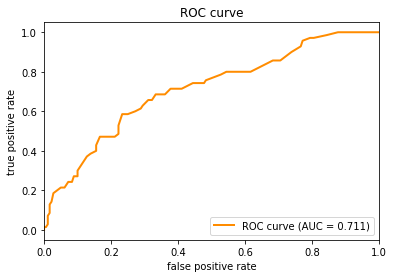

<Figure size 432x288 with 0 Axes>

In [35]:
validate(RF_clf, X_test_ohe, y_test)

#### --> Normally you would evaluate multiple feature engineering approaches, classifiers and hyperparameter settings with K-fold cross-validation / GridSearchCV / automl. We keep it simple for the sake of brevity here.

# ------------------------------------------------------------------------------------------------------
# PART 3
## HOW DO I REPRODUCE THESE STEPS IN NEAR-REAL-TIME IN THE PRODUCTION ENVIRONMENT?
#### At the time of prediction, the data streamed into our classifier .predict() method will look like this:

In [36]:
display(df_original.iloc[:,:-1].head(5))

,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Gender,Purchase_date,Birth_date,Device
131,2,own,little,little,6887,36,education,male,2020-03-12,1991-03-12,Samsung Fantastic
203,2,rent,little,little,902,12,education,male,2020-02-24,1999-02-24,Ericsson Very Old
50,1,own,NaN,moderate,2333,24,furniture/equipment,male,2020-04-26,1991-04-26,Nokia Old
585,2,rent,little,little,2039,18,furniture/equipment,female,2020-02-02,2000-02-02,Huawei Awesome
138,2,own,NaN,moderate,2728,15,radio/TV,male,2020-01-16,1985-01-16,iPhone 9


#### ...missing values, purchase date instead of day of the week, birth date instead of age, full device model name, not one-hot encoded, etc.

In [37]:
# Utility step: create a dedicated output directory
model_training_timestamp = '{:%Y-%b-%d_%H-%M-%S}'.format(datetime.datetime.now())
print('Model training completed on ', model_training_timestamp,'.')
print('Creating dedicated output directory...')
dirName = '../output/%s/' % (model_training_timestamp)
 
try:
    # Create target directory
    os.mkdir(dirName)
    os.mkdir(dirName+'one_by_one')
    os.mkdir(dirName+'standard_pipeline')
    os.mkdir(dirName+'e2e_pipeline')
    print("Directory " , dirName ,  "successfully created.")
except FileExistsError:
    print("ERROR: Directory " , dirName ,  "already exists!")

Model training completed on  2020-May-26_11-59-56 .
Creating dedicated output directory...
Directory  ../output/2020-May-26_11-59-56/ successfully created.


## Method 1: Reproduce data cleaning, feature engineering, feature preprocessing one by one in the production code
## (NOT RECOMMENDED)

In [38]:
# Save all the fitted preprocessors to a directory
print('Saving all fitted preprecessors...')
joblib.dump(dict_vec, dirName+'one_by_one/dict_vec.pkl')
joblib.dump(my_imputer, dirName+'one_by_one/my_imputer.pkl')
joblib.dump(my_scaler, dirName+'one_by_one/my_scaler.pkl')
joblib.dump(RF_clf, dirName+'one_by_one/RF_clf.pkl')
print('Saved in ', dirName, '.')

Saving all fitted preprecessors...
Saved in  ../output/2020-May-26_11-59-56/ .


In [39]:
### Create a code snippet / .py module that does all the preprocessing and prediction in one go - something like the code below.

# Read in saved objects from the production "output" directory
dict_vec_prod = joblib.load(dirName+'one_by_one/dict_vec.pkl')
my_imputer_prod = joblib.load(dirName+'one_by_one/my_imputer.pkl')
my_scaler_prod = joblib.load(dirName+'one_by_one/my_scaler.pkl')
RF_clf_prod = joblib.load(dirName+'one_by_one/RF_clf.pkl')

# Define a predict function with all the preprocessing steps
def predict(df):
    # Filling missing values
    for column in df[['Saving accounts', 'Checking account']]:
        df[column] = df[column].fillna('Missing')
    
    # Casting "Job" column to string
    df['Job'] = df['Job'].astype(str)
    print('Done.')
    
    # Engineering "Age" feature
    reference_date_column = 'Purchase_date'
    birth_date_column = 'Birth_date'
    df['Age'] = df.apply(lambda row: create_age_column(row, reference_date_column, birth_date_column), axis=1)
    
    # Engineering day of week feature 
    df['Purchase_weekday'] = df['Purchase_date'].map(lambda x: find_day_of_week(x))
    
    # Engineering binary iPhone-Other device feature
    df['Device'] = df['Device'].map(lambda x: identify_device(str(x)))
    
    # Dropping purchase date and birth date columns
    df.drop(['Purchase_date', 'Birth_date'], axis=1, inplace=True)
    
    # One-hot encoding
    df_ohe = df.to_dict(orient='records')
    df_ohe = dict_vec_prod.transform(df_ohe)
    
    # Imputation of missing values and feature scaling
    df_ohe = my_imputer_prod.transform(df_ohe)
    df_ohe = my_scaler_prod.transform(df_ohe)
    
    # Making a prediction
    pred = RF_clf_prod.predict_proba(df_ohe)

    return pred


def calculate_age(reference_date, birth_date):
    days_in_year = 365.2425
    try:
        age = int((pd.to_datetime(reference_date, infer_datetime_format=True) - pd.to_datetime(birth_date, infer_datetime_format=True)).days / days_in_year)
    except:
        age = None

    return age


def create_age_column(row, reference_date_column, birth_date_column):
    return calculate_age(row[reference_date_column], row[birth_date_column])


def find_day_of_week(date_string):
    recognized_date = pd.to_datetime(date_string, infer_datetime_format=True)

    return calendar.day_name[recognized_date.weekday()]


def identify_device(string):
    if 'iphone' in string.lower():
        return 'iPhone'
    else:
        return 'Other'

#### Let's try to make a prediction. Will it work?

In [40]:
print('Let\'s try to make a prediction. Will it work?')
input_data = df_original.iloc[:,:-1].head(1)
print('Predicted probabilities:', predict(input_data))
print('It worked!')

Let's try to make a prediction. Will it work?
Done.
Predicted probabilities: [[0.11 0.89]]
It worked!


### It works. However, the above approach is a bad idea. Here's why:
### --> We need to maintain the same code in two places - it's easy to make mistakes and lose consistency between the two.
### --> We need to explain a lot to developers deploying and maintaining your code
### -->The deployment team might modify your code (intentionally or unintentionally)
### --> You directly reveal the entire feature engineering and model tuning know-how to anyone who has access to your code

--------

## Method 2: Use sklearn pipeline to package the standard sklearn preprocessors into a single "model pipeline" object
## (SLIGHTLY BETTER, BUT STILL NOT GREAT...)

According to sklearn documentation (https://scikit-learn.org/stable/modules/compose.html#pipeline-chaining-estimators):

**Pipeline** can be used to **chain multiple estimators into one**. This is useful as there is often a fixed sequence of steps in processing the data, for example feature selection, normalization and classification. Pipeline serves multiple purposes here:

**Convenience and encapsulation**
* You only have to call fit and predict once on your data to fit a whole sequence of estimators.

**Joint parameter selection**
* You can grid search over parameters of all estimators in the pipeline at once.

**Safety**
* Pipelines help avoid leaking statistics from your test data into the trained model in cross-validation, by ensuring that the same samples are used to train the transformers and predictors.

### Sklearn pipeline **works out of the box for preprocessors included in the sklearn library**, such as DictVectorizer(), Imputer() or StandardScaler(), and many others.

### Let's give it a try!

#### Define pipeline steps

In [41]:
# We can chain together the last four steps of our "predict" workflow into a single pipeline like this:
standard_pipeline = Pipeline([('ohe', DictVectorizer()),
                              ('imputation', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                              ('scaling', StandardScaler(with_mean=False)),
                              ('classifier', RF_clf)])

#### Fit (train) the pipeline on the training set

In [42]:
# We can then fit (train) the pipeline on our training data - directly after having done the train/test split:
standard_pipeline.fit(X_train.to_dict(orient='records'), y_train)

Pipeline(memory=None,
     steps=[('ohe', DictVectorizer(dtype=<class 'numpy.float64'>, separator='=', sort=True,
        sparse=True)), ('imputation', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='most_frequent', verbose=0)), ('scaling', StandardScaler(copy=True, with_mean=False, with_std=Tru...tors=100, n_jobs=None,
            oob_score=False, random_state=123, verbose=0, warm_start=False))])

#### Evaluate the pipeline on the test set

area_under_curve: 0.711
accuracy: 0.732
log_loss: 0.538
precision: 0.531
recall: 0.371
specificity: 0.872
f1_score: 0.437

confusion_matrix:
[[157, 23], [44, 26]]

roc_curve:


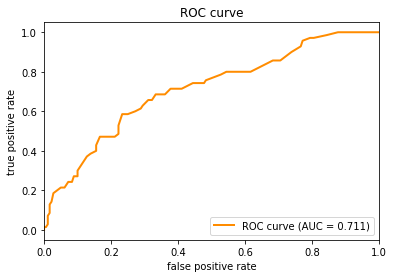

<Figure size 432x288 with 0 Axes>

In [43]:
validate(standard_pipeline, X_test.to_dict(orient='records'), y_test)

#### We now only need to save one object instead of four

In [44]:
# Save the fitted pipeline to a directory
print('Saving the fitted pipeline...')
joblib.dump(standard_pipeline, dirName+'standard_pipeline/standard_pipeline.pkl')
print('Saved in ', dirName, '.')

Saving the fitted pipeline...
Saved in  ../output/2020-May-26_11-59-56/ .


#### We can also shorten our predict() function

In [45]:
### Create a code snippet / .py module that does all the preprocessing and prediction in one go - something like the code below.

# Read in saved objects from the production "output" directory
standard_pipeline_prod = joblib.load(dirName+'standard_pipeline/standard_pipeline.pkl')

# Define a predict function with all the preprocessing steps
def predict_standard_pipeline(df):
    # Filling missing values
    for column in df[['Saving accounts', 'Checking account']]:
        df[column] = df[column].fillna('Missing')
    
    # Casting "Job" column to string
    df['Job'] = df['Job'].astype(str)
    print('Done.')
    
    # Engineering "Age" feature
    reference_date_column = 'Purchase_date'
    birth_date_column = 'Birth_date'
    df['Age'] = df.apply(lambda row: create_age_column(row, reference_date_column, birth_date_column), axis=1)
    
    # Engineering day of week feature 
    df['Purchase_weekday'] = df['Purchase_date'].map(lambda x: find_day_of_week(x))
    
    # Engineering binary iPhone-Other device feature
    df['Device'] = df['Device'].map(lambda x: identify_device(str(x)))
    
    # Dropping purchase date and birth date columns
    df.drop(['Purchase_date', 'Birth_date'], axis=1, inplace=True)
    
    # One-hot encoding
    df_ohe = df.to_dict(orient='records')
    #df_ohe = dict_vec_prod.transform(df_ohe)
    
    # Imputation of missing values and feature scaling
    #df_ohe = my_imputer_prod.transform(df_ohe)
    #df_ohe = my_scaler_prod.transform(df_ohe)
    
    # Making a prediction
    pred = standard_pipeline_prod.predict_proba(df_ohe)

    return pred


def calculate_age(reference_date, birth_date):
    days_in_year = 365.2425
    try:
        age = int((pd.to_datetime(reference_date, infer_datetime_format=True) - pd.to_datetime(birth_date, infer_datetime_format=True)).days / days_in_year)
    except:
        age = None

    return age


def create_age_column(row, reference_date_column, birth_date_column):
    return calculate_age(row[reference_date_column], row[birth_date_column])


def find_day_of_week(date_string):
    recognized_date = pd.to_datetime(date_string, infer_datetime_format=True)

    return calendar.day_name[recognized_date.weekday()]


def identify_device(string):
    if 'iphone' in string.lower():
        return 'iPhone'
    else:
        return 'Other'

#### Does it work?

In [46]:
print('Let\'s try to make a prediction. Will it work?')
input_data = df_original.iloc[:,:-1].head(1)
print('Predicted probabilities:', predict_standard_pipeline(input_data))
print('It worked!')

Let's try to make a prediction. Will it work?
Done.
Predicted probabilities: [[0.11 0.89]]
It worked!


### We still have to maintain data cleaning and feature engineering code in two separate places though.
### Can we somehow embed our customized data cleaning and feature engineering steps into an sklearn pipeline?
### Yes, we can!
----------

## Method 3: Package data cleaning, feature engineering, preprocessing and final classifier into one single pipeline
## (MUCH BETTER!)

#### We need to somehow package the following steps into a pipeline object:
* Filling missing values in the categorical "saving accounts" and "checking account" columns
* Casting "Job" column to string
* Engineering "Age" feature
* Engineering "Day of week" feature
* Engineering binary iPhone-Other device feature
* Dropping purchase date and birth date columns

#### --> We need to code up our own custom transfomer classes, which can be instantiated and included as objects in an sklearn pipeline

#### In practice, it's less difficult than it sounds. Each of our classes needs the following:
#### --> inherit from sklearn base `BaseEstimator` and `TransformerMixin` classes (you don't need to understand how these base classes work in detail)
#### --> have its own `fit()` and `transform()` methods

Let's give it a try!

In [ ]:
#from src.pipeline_components import MissingValFiller, StringCaster, AgeEncoder, DayOfWeekEncoder, DeviceEncoder
#from src.pipeline_components import WhitespaceRemover, OriginalDtypesCaster, DfDict

In [48]:
from sklearn.base import BaseEstimator, TransformerMixin

# Custom transformer for filling missing values in the categorical "saving accounts" and "checking account" columns
class MissingValFiller(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.cols_to_fill = None

    def fit(self, features_df, labels_df=None, columns_to_fill=None):
        if columns_to_fill is None:
            self.cols_to_fill = ['Saving accounts', 'Checking account']
        else:
            self.cols_to_fill = columns_to_fill

        return self

    def transform(self, features_df):
        transformed_df = features_df.copy()
        for column in transformed_df[self.cols_to_fill]:
            transformed_df[column] = transformed_df[column].fillna('Missing')

        return transformed_df

#### Let's test it on some input

In [49]:
input_data = df_original.iloc[:,:-1].head()
print('Original data:')
display(input_data)

test_filler = MissingValFiller()
test_filler.fit(input_data)
transformed_input_data = test_filler.transform(input_data)

print('Transformed data:')
display(transformed_input_data)

Original data:


,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Gender,Purchase_date,Birth_date,Device
131,2,own,little,little,6887,36,education,male,2020-03-12,1991-03-12,Samsung Fantastic
203,2,rent,little,little,902,12,education,male,2020-02-24,1999-02-24,Ericsson Very Old
50,1,own,NaN,moderate,2333,24,furniture/equipment,male,2020-04-26,1991-04-26,Nokia Old
585,2,rent,little,little,2039,18,furniture/equipment,female,2020-02-02,2000-02-02,Huawei Awesome
138,2,own,NaN,moderate,2728,15,radio/TV,male,2020-01-16,1985-01-16,iPhone 9


Transformed data:


,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Gender,Purchase_date,Birth_date,Device
131,2,own,little,little,6887,36,education,male,2020-03-12,1991-03-12,Samsung Fantastic
203,2,rent,little,little,902,12,education,male,2020-02-24,1999-02-24,Ericsson Very Old
50,1,own,Missing,moderate,2333,24,furniture/equipment,male,2020-04-26,1991-04-26,Nokia Old
585,2,rent,little,little,2039,18,furniture/equipment,female,2020-02-02,2000-02-02,Huawei Awesome
138,2,own,Missing,moderate,2728,15,radio/TV,male,2020-01-16,1985-01-16,iPhone 9


#### Great. Now let's code up the rest of the custom transformers!

In [50]:
# Custom transformer for casting "Job" column to string
class StringCaster(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.cols_to_cast = None

    def fit(self, features_df, labels_df=None, columns_to_cast=None):
        if columns_to_cast is None:
            self.cols_to_cast = ['Job']
        else:
            self.cols_to_cast = columns_to_cast

        return self

    def transform(self, features_df):
        transformed_df = features_df.copy()
        for column in transformed_df[self.cols_to_cast]:
            transformed_df[column] = transformed_df[column].astype(str)

        return transformed_df

# Custom transformer for engineering "Age" feature
class AgeEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.reference_date_column = None
        self.birth_date_column = None

    def fit(self, features_df, labels_df=None, r_date_col=None, b_date_col=None):
        if r_date_col is None or b_date_col is None:
            self.reference_date_column = 'Purchase_date'
            self.birth_date_column = 'Birth_date'
        else:
            self.reference_date_column = r_date_col
            self.birth_date_column = b_date_col

        return self

    def transform(self, features_df):
        transformed_df = features_df.copy()
        transformed_df['Age'] = transformed_df.apply(lambda row: self.create_age_column(row), axis=1)
        transformed_df.drop([self.birth_date_column], axis=1, inplace=True)

        return transformed_df

    def calculate_age(self, referenceDate, birthDate):
        days_in_year = 365.2425
        try:
            age = int((pd.to_datetime(referenceDate, infer_datetime_format=True) - pd.to_datetime(str(birthDate), infer_datetime_format=True)).days / days_in_year)
        except:
            age = None

        return age

    def create_age_column(self, row):
        return self.calculate_age(row[self.reference_date_column], row[self.birth_date_column])


# Customer transformer for engineering "Day of week" feature
class DayOfWeekEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.date_column = None

    def fit(self, features_df, labels_df=None, date_col=None):
        if date_col is None:
            self.date_column = 'Purchase_date'
        else:
            self.date_column = date_col

        return self

    def transform(self, features_df):
        transformed_df = features_df.copy()
        transformed_df['Weekday'] = transformed_df[self.date_column].map(lambda x: self.find_day_of_week(x))
        transformed_df.drop([self.date_column], axis=1, inplace=True)

        return transformed_df

    def find_day_of_week(self, string):
        recognized_date = pd.to_datetime(string, infer_datetime_format=True)

        return calendar.day_name[recognized_date.weekday()]


# Custom transformer for engineering binary iPhone-Other device feature
class DeviceEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.device_column = None

    def fit(self, features_df, labels_df=None, device_col=None):
        if device_col is None:
            self.device_column = 'Device'
        else:
            self.device_column = device_col

        return self

    def transform(self, features_df):
        transformed_df = features_df.copy()
        transformed_df.loc[:, self.device_column] = transformed_df[self.device_column].map(
            lambda x: self.identify_device(str(x)))

        return transformed_df

    def identify_device(self, string):
        if 'iphone' in string.lower():
            return 'iPhone'
        else:
            return 'Other'

#### Let's build and test our custom preprocessing pipeline

In [51]:
test_preprocessing_pipeline = Pipeline([
    ('value_filler', MissingValFiller()),
    ('string_caster', StringCaster()),
    ('age_encoder', AgeEncoder()),
    ('day_of_week_encoder', DayOfWeekEncoder()),
    ('device_encoder', DeviceEncoder())
])

input_data = df_original.iloc[:,:-1].head(5)
print('Original data:')
display(input_data)

test_preprocessing_pipeline.fit(input_data)
transformed_input_data = test_preprocessing_pipeline.transform(input_data)

print('Transformed data:')
display(transformed_input_data)
print()
print('It works!')

Original data:


,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Gender,Purchase_date,Birth_date,Device
131,2,own,little,little,6887,36,education,male,2020-03-12,1991-03-12,Samsung Fantastic
203,2,rent,little,little,902,12,education,male,2020-02-24,1999-02-24,Ericsson Very Old
50,1,own,NaN,moderate,2333,24,furniture/equipment,male,2020-04-26,1991-04-26,Nokia Old
585,2,rent,little,little,2039,18,furniture/equipment,female,2020-02-02,2000-02-02,Huawei Awesome
138,2,own,NaN,moderate,2728,15,radio/TV,male,2020-01-16,1985-01-16,iPhone 9


Transformed data:


,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Gender,Device,Age,Weekday
131,2,own,little,little,6887,36,education,male,Other,29,Thursday
203,2,rent,little,little,902,12,education,male,Other,20,Monday
50,1,own,Missing,moderate,2333,24,furniture/equipment,male,Other,29,Sunday
585,2,rent,little,little,2039,18,furniture/equipment,female,Other,20,Sunday
138,2,own,Missing,moderate,2728,15,radio/TV,male,iPhone,34,Thursday



It works!


## HOW ABOUT ADDITIONAL ERROR HANDLING ON THE FLY?

#### Sample production deployment errors / issues:

#### --> string data is entered with a preceding or trailing whitespaces, e.g. " iPhone" instead of "iPhone"

#### --> data sent to the API (e.g. in json format) has a different type than the original training data (e.g. integer instead of float, string intead of integer, etc.) 

#### Luckily, we can code up custom transformers to deal with these (and many other) issues!

In [52]:
# Transformer for preceding and trailing whitespaces
class WhitespaceRemover(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def remove_whitespace(self, features_df):
        for col in features_df:
            if features_df[col].dtype == 'object':
                features_df[col] = features_df[col].str.strip()
        return features_df

    def fit(self, features_df=None, labels_df=None):
        return self

    def transform(self, features_df):
        transformed_df = features_df.copy()
        transformed_df = self.remove_whitespace(transformed_df)
        
        return transformed_df


# Transformer for casting data into types present in original training data
class OriginalDtypesCaster(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.column_types = {}

    def fit(self, features_df, labels_df=None):
        dtypes = features_df.dtypes
        dtypes_col = dtypes.index
        dtypes_type = [i.name for i in dtypes.values]
        self.column_types = dict(zip(dtypes_col, dtypes_type))

        return self

    def transform(self, features_df):
        transformed_df = features_df.copy()
        transformed_df = transformed_df.astype(self.column_types)

        return transformed_df

## LET'S BUILD OUR FINAL E2E PIPELINE

#### Before doing so, we need to define one more utility transformer class...

In [53]:
# Transformer for transforming df to a dict (needed input format for DictVectorizer)
class DfDict(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, features_df, labels_df=None):
        return self

    def transform(self, features_df):
        return features_df.to_dict('records')

#### Additionally, as best practice, let's import the transformers from an external "src" module.

In [55]:
from src.pipeline_components import MissingValFiller, StringCaster, AgeEncoder, DayOfWeekEncoder, DeviceEncoder
from src.pipeline_components import WhitespaceRemover, OriginalDtypesCaster, DfDict

In [56]:
# Create separate object for target variable
y = df_original['Risk_label']
# Create separate object for input features
X = df_original.drop('Risk_label', axis=1)

# Split X and y into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

#### Definining the final e2e pipeline consisting of 12 steps - 7 of which are our own custom transformers

In [57]:
e2e_pipeline = Pipeline([
    ('whitespace_remover', WhitespaceRemover()),
    ('original_dtypes_caster', OriginalDtypesCaster()),
    ('value_filler', MissingValFiller()),
    ('string_caster', StringCaster()),
    ('age_encoder', AgeEncoder()),
    ('day_of_week_encoder', DayOfWeekEncoder()),
    ('device_encoder', DeviceEncoder()),
    ('df_dict', DfDict()),
    ('dict_vec', DictVectorizer()),
    ('imputation', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('scaling', StandardScaler(with_mean=False)),
    ('classifier', RF_clf)
])

In [58]:
print('Fitting the pipeline...')
# We can then fit (train) the pipeline on our training data - directly after having done the train/test split:
e2e_pipeline.fit(X_train, y_train)
print('Done.')

Fitting the pipeline...
Done.


Evaluation metrics:
area_under_curve: 0.698
accuracy: 0.744
log_loss: 0.549
precision: 0.562
recall: 0.386
specificity: 0.883
f1_score: 0.458

confusion_matrix:
[[159, 21], [43, 27]]

roc_curve:


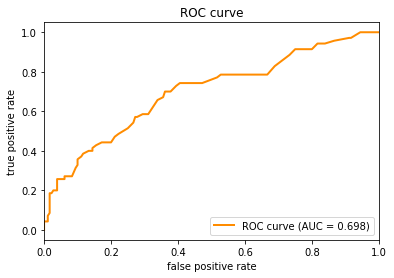

<Figure size 432x288 with 0 Axes>

In [59]:
print('Evaluation metrics:')
validate(e2e_pipeline, X_test, y_test)

#### We now only need to save one object

In [60]:
# Save the fitted pipeline to a directory
print('Saving the fitted pipeline...')
joblib.dump(e2e_pipeline, dirName+'e2e_pipeline/e2e_pipeline.pkl')
print('Saved in ', dirName, '.')

Saving the fitted pipeline...
Saved in  ../output/2020-May-26_11-59-56/ .


#### We can also shorten our predict() function

In [61]:
### Create a code snippet / .py module that does all the preprocessing and prediction in one go - something like the code below.
from src.pipeline_components import MissingValFiller, StringCaster, AgeEncoder, DayOfWeekEncoder, DeviceEncoder
from src.pipeline_components import WhitespaceRemover, OriginalDtypesCaster, DfDict

# Read in saved objects from the production "output" directory
e2e_pipeline_prod = joblib.load(dirName+'e2e_pipeline/e2e_pipeline.pkl')

# Define a predict function with all the preprocessing steps
def predict_e2e_pipeline(df):    
    print('Making a prediction...')
    pred = e2e_pipeline_prod.predict_proba(df)
    print()
    
    return pred

#### Does it work?

In [62]:
print('Let\'s try to make a prediction. Will it work?')
input_data = X_test.head(1)
print('Predicted probabilities:', predict_e2e_pipeline(input_data))
print('It worked!')

Let's try to make a prediction. Will it work?
Making a prediction...

Predicted probabilities: [[0.96 0.04]]
It worked!


# ------------------------------------------------------------------------------------------------------
# PART 4
## FINALLY, LET'S PACKAGE OUR PIPELINE INTO A REST API WITH FLASK

#### First, let's generate and save some data that the API will need:
* test features
* test predictions
* column names
* column data types

In [63]:
### Generate test data for API
smoke_test_features = X_test.head(5)
#display(smoke_test_features)

with open(dirName+'e2e_pipeline/test_request_body.json', 'w') as fp:
    json.dump(smoke_test_features.to_dict(orient='records'),
              fp,
              sort_keys=True,
              indent=2,
              default=str)

smoke_predictions = e2e_pipeline.predict_proba(smoke_test_features)[:,1].tolist()
with open(dirName+'e2e_pipeline/test_response_body.json', 'w') as fp:
    json.dump(smoke_predictions,
              fp,
              sort_keys=True,
              indent=2)

In [64]:
# Saving column names so that we can order incoming prediction data correctly
column_names = smoke_test_features.columns.tolist()
with open(dirName+'e2e_pipeline/column_names.txt', 'w') as f:
    for col in column_names:
        f.write(str(col) +'\n')

In [65]:
# Saving column dtypes
column_dtypes = smoke_test_features.dtypes.apply(lambda x: x.name).to_dict()
for key in column_dtypes:
    if column_dtypes[key] == 'datetime64[ns]':
        column_dtypes[key] = 'object'
        
with open(dirName+'e2e_pipeline/column_dtypes.json', 'w') as fp:
    json.dump(column_dtypes,
              fp,
              sort_keys=True,
              indent=2,
              default=str)

In [66]:
# Copying app.py into e2e_pipeline directory'
copyfile('../prediction-api/app.py', dirName+'e2e_pipeline/app.py')

'../output/2020-May-26_11-59-56/e2e_pipeline/app.py'

#### Let's make test predictions to later compare them with the API response

In [67]:
print(smoke_predictions)

[0.04, 0.65, 0.2, 0.55, 0.35]


#### Now let's go to the output directory and run the REST API app!
##### (This exercise takes place outside of this notebook)
#### --> In the command line interface, go to the output directory --> timestamp of model training --> e2e_pipeline
#### --> Activate conda environment
#### --> Run `python app.py` command
#### --> The API's `/predict` endpoint will be available under `http://0.0.0.0:5000/predict` in your browser
#### --> Try sending data from `test_request_body.json` to the above endpoint, e.g. with Postman
#### --> Have a look at the `app.py` script to see how a minimalistic model serving API can be implemented
----------
----------

#### This notebook and entire project have been run and tested on the following system and key dependencies:

In [ ]:
print('Operating system:', platform.system())
print('OS release:', platform.release())
print('Machine:', platform.machine())
print('Platform:', platform.platform())
print('Version:', platform.version())
print()
print('Python version: {}'.format(sys.version))
print('Pandas version: {}'.format(pd.__version__))
print('Numpy version: {}'.format(np.__version__))
print('Scikit-learn version: {}'.format(sklearn.__version__))